<a href="https://colab.research.google.com/github/AndrewLoweUoM/lake_district/blob/main/Crowden_Runoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ARIMA predict Crowden runoff from rainfall S50**

---



In [ ]:
#ARIMA model to fit a timeseries of temperature to flow
#Change % split of training, and p.d.q values
#IMPORT LIBARIES
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for numerical operations
from google.colab import drive # used in Google Colab notebooks to mount Google Drive
import matplotlib.pyplot as plt # for plotting a graph.
import matplotlib.dates as mdates # for plotting dates on graphs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import itertools
import warnings
warnings.filterwarnings("ignore")

# NAME AND STUDENT ID
print('Andrew Lowe')
print ('ID 1223456')

# LOAD DATA CSV FILES

# Mount Google Drive
drive.mount('/content/drive/', force_remount=True)

# Load the temperature and observed flow data in CSV file from Google Drive
#file_path = '/content/drive/MyDrive/dataset/crowden_river_data.csv'
#file_path = '/content/drive/MyDrive/dataset/crowden_river_data_v1.csv'
file_path = '/content/drive/MyDrive/dataset/crowden_river_data_2018_hr.csv'

# Read climate data from CSV file and create a DataFrame
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')


# SPLIT DATA INTO TRAINING AND TEST SETS AND PREPARE DATA SETS

# Split the data into training and testing sets (30% training, 70% testing then 50%).
split_index = int(0.3 * len(df)) # % of the data for training

# The df[:split_index] is called DataFrame slicing, where the train_data = df[:split_index] creates a new DataFrame called train_data containing the first split_index rows of the original DataFrame df
train_data = df[:split_index] # Training data contains the first % of the data
test_data = df[split_index:] # Testing data contains the remaining 0% of the data

#print(train_data.columns)

# Prepare the training and testing data. This reads columns 2 (Temp) and 3 (Observed Flow) from CSV file
rain_X_train = train_data[['Rainfall']].values
flow_y_train = train_data['Flow'].values
rain_X_test = test_data[['Rainfall']].values
flow_y_test = test_data['Flow'].values
date_test = test_data ['Date']


# MAKE PREDICTION OF FLOW USING ARIMA ON TESTING DATA

# Fit ARIMA model to training data using predefined p, d, q parameters
#order = (2, 1, 3)  # Define order of ARIMA model
#model = ARIMA(flow_y_train, order=order)
#arima_results = model.fit()

# Make predictions on testing data
#flow_y_pred = arima_results.forecast(steps=len(temp_X_test))

# DEFINE p, d, q PARAMETER VALUES AND MAKE PREDICTION OF FLOW USING ARIMA ON TESTING DATA

# Define range of values for p, d, q
p_values = range(0, 5)  # Autoregression order
d_values = range(0, 3)  # Differencing order
q_values = range(0, 5)  # Moving average order

best_aic = float("inf") # Initialize best AIC
best_order = None

# Iterate over all combinations of p, d, q values
for p, d, q in itertools.product(p_values, d_values, q_values):
    order = (p, d, q)
    try:
        # Fit ARIMA model
        model = ARIMA(flow_y_train, order=order)
        arima_results = model.fit()

#       # Calculate AIC
        aic = arima_results.aic
#
        # Update best AIC and order if current model has lower AIC
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except:
        continue

print("Best AIC:", best_aic)
print("Best Order (p, d, q):", best_order)

# Fit ARIMA model with best order
best_model = ARIMA(flow_y_train, order=best_order)
best_arima_results = best_model.fit()


# Make predictions using ARIMA on testing data
flow_y_pred = best_arima_results.forecast(steps=len(rain_X_test))

print('flow_y_pred')

# EVALUATE MODEL PERFORMACE

# EVALUATE THE ARIMA MODEL PERFORMANCE

# Calculate the R-squared score
#score = r2_score(flow_y_test, flow_y_pred)
#print('R-squared score:', score)

# EVALUATE THE PERFORMANCE OF THE GLACIER RUNOFF MODEL

# Evaluate runoff model results (1) with simple r2 and mean standard error (mse)

# Calculate evaluation metrics for total predicted flow
r2 = r2_score(flow_y_test, flow_y_pred)
mse = mean_squared_error(flow_y_test, flow_y_pred)

# Print evaluation metrics for total predicted flow
print("Evaluation Metrics for Total Predicted Flow:")
print(f"R2: {r2:.2f}")
print(f"MSE: {mse:.2f}")

# Evaluate runof model results (2) using Nash-Sutcliffe Efficiency (NSE)and PBIAS

# Prepare to calculate Nash-Sutcliffe Efficiency (NSE)and PBIAS

# Observed and predicted values
observed_values = flow_y_test
predicted_values = flow_y_pred

# Calculate mean of observed values
observed_mean = np.mean(observed_values)

# Calculate Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observed_values - predicted_values) ** 2) / np.sum((observed_values - observed_mean) ** 2))

# Calculate Percent Bias (PBIAS)
pbias = (np.sum(observed_values - predicted_values) / np.sum(observed_values)) * 100

print("Nash-Sutcliffe Efficiency (NSE):", nse)
print("Percent Bias (PBIAS):", pbias)


# CREATE SCATTER PLOT OF TEMPERATURE AND PREDICTED FLOW FOR TEST DATA

# Plot outputs
plt.scatter(rain_X_test, flow_y_test, color="black")
plt.plot(rain_X_test, flow_y_pred, color="blue", linewidth=3)

plt.xlabel('Rain')
plt.ylabel('Predicted Flow')
plt.title('ARIMA: Rainfall vs Flow')

plt.show()


# CREATE TIME SERIES PLOT OF OBSERVED FLOW and PREDICTED FLOW FOR TEST PERIOD

# Plot time series of observed flow and predicted flow
plt.figure(figsize=(12, 6))
plt.plot(date_test, flow_y_test, label='Observed Flow', color='blue')
plt.plot(date_test, flow_y_pred, label='Predicted Flow', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Flow (cumecs)')
plt.title('ARIMA: Time Series of Observed Flow and Predicted Runoff')
plt.legend()

#Set range for y-axis
plt.ylim(0, 1)

# Set x-axis major and minor intervals
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Major interval: 7 day
#plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))  # Minor interval: 100 hours
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format the major ticks as 'DD-MM-YYYY'

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Plot GRID
plt.grid(True)
plt.tight_layout()

plt.show()


# WRITE MODEL RESULTS TO CSV FILE

# Write the predictions to a file on Google Drive and confirm file is saved

# Convert multi-dimensional arrays to one-dimensional arrays if necessary
rain_X_test = rain_X_test.ravel()  # Ensure temp_X_test is one-dimensional
flow_y_pred = flow_y_pred.ravel()  # Ensure flow_y_pred is one-dimensional

# Create DataFrame with one-dimensional arrays
#results_df = pd.DataFrame({'Time_hr': date_test,'Rain': rain_X_test, 'Flow': flow_y_test, 'Predicted Flow': flow_y_pred})
#results_df = pd.DataFrame({'Rain': rain_X_test, 'Flow': flow_y_test, 'Predicted Flow': flow_y_pred})

# Write the DataFrame to a CSV file
#results_df.to_csv('/content/drive/MyDrive/dataset/output/crowden_pred_ARIMA_ML_flow.csv', index=False)

#print("File saved successfully!")

**LSTM Crowden**

Mounted at /content/drive/
Epoch 1/75
19/19 [==============================] - 4s 3ms/step - loss: 0.0379
Epoch 2/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 3/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 4/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 5/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 6/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 7/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 8/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0274
Epoch 9/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0274
Epoch 10/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 11/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 12/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 13/75
19/19 [===

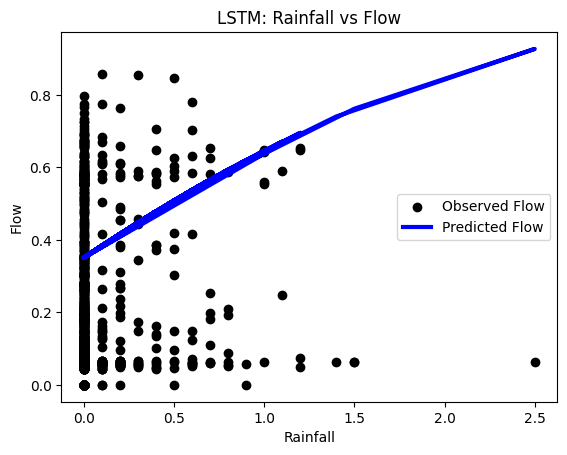

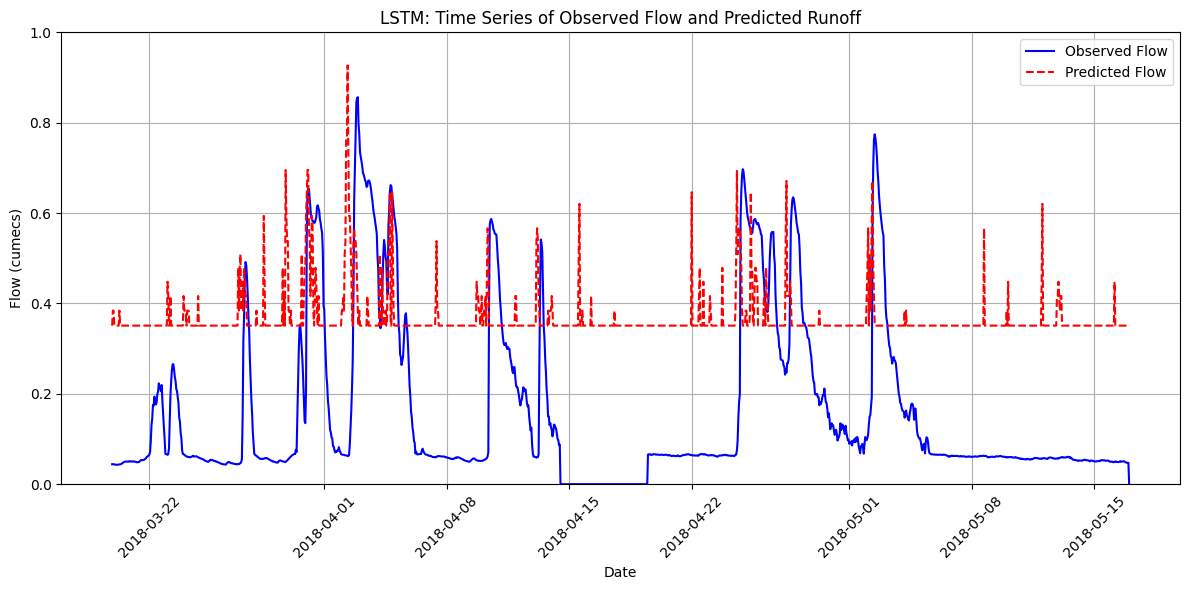

In [13]:
#LSTM Model for predicting river flow based on rainfall
#Change % split, number of LSTM units, number of epochs, and batch size
#IMPORT LIBARIES
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Mount Google Drive
drive.mount('/content/drive/', force_remount=True)

# Load the data
#file_path = '/content/drive/MyDrive/dataset/crowden_river_data.csv'
#file_path = '/content/drive/MyDrive/dataset/crowden_river_data_v1.csv'
file_path = '/content/drive/MyDrive/dataset/crowden_river_data_2018_hr.csv'

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')

# Split the data into training and testing sets
split_index = int(0.3 * len(df))

train_data = df[:split_index]
test_data = df[split_index:]

# Prepare the training and testing data
rain_X_train = train_data[['Rainfall Woodhead']].values
flow_y_train = train_data['Flow'].values
rain_X_test = test_data[['Rainfall Woodhead']].values
flow_y_test = test_data['Flow'].values
date_test = test_data['Date'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
rain_X_train_scaled = scaler.fit_transform(rain_X_train)
rain_X_test_scaled = scaler.transform(rain_X_test)

# Reshape data for LSTM
rain_X_train_reshaped = rain_X_train_scaled.reshape((-1, 1, 1))
rain_X_test_reshaped = rain_X_test_scaled.reshape((-1, 1, 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=25, input_shape=(1, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
#model.fit(rain_X_train_reshaped, flow_y_train, epochs=100, batch_size=32)
model.fit(rain_X_train_reshaped, flow_y_train, epochs=75, batch_size=32)

# Make predictions
flow_y_pred_scaled = model.predict(rain_X_test_reshaped)
flow_y_pred = scaler.inverse_transform(flow_y_pred_scaled)

# Evaluate the model
score = r2_score(flow_y_test, flow_y_pred)
mse = mean_squared_error(flow_y_test, flow_y_pred)
print('R-squared score:', score)
print('Mean Squared Error:', mse)

# Prepare to calculate Nash-Sutcliffe Efficiency (NSE)and PBIAS

# Observed and predicted values
observed_values = flow_y_test
predicted_values = flow_y_pred

# Calculate mean of observed values
observed_mean = np.mean(observed_values)

# Calculate Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observed_values - predicted_values) ** 2) / np.sum((observed_values - observed_mean) ** 2))

# Calculate Percent Bias (PBIAS)
pbias = (np.sum(observed_values - predicted_values) / np.sum(observed_values)) * 100

print("Nash-Sutcliffe Efficiency (NSE):", nse)
print("Percent Bias (PBIAS):", pbias)

# Plot outputs
plt.scatter(rain_X_test, flow_y_test, color='black', label='Observed Flow')
plt.plot(rain_X_test, flow_y_pred, color='blue', linewidth=3, label='Predicted Flow')
plt.xlabel('Rainfall')
plt.ylabel('Flow')
plt.title('LSTM: Rainfall vs Flow')
plt.legend()
plt.show()

# Plot time series of observed flow and predicted flow
plt.figure(figsize=(12, 6))
plt.plot(date_test, flow_y_test, label='Observed Flow', color='blue')
plt.plot(date_test, flow_y_pred, label='Predicted Flow', linestyle='--', color='red')
#plt.plot(flow_y_test, label='Observed Flow', color='blue')
#plt.plot(flow_y_pred, label='Predicted Flow', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Flow (cumecs)')
plt.title('LSTM: Time Series of Observed Flow and Predicted Runoff')
plt.legend()

#Set range for y-axis
plt.ylim(0, 1)

# Set x-axis major and minor intervals
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Major interval: 1 day
#plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=100))  # Minor interval: 6 hours
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format the major ticks as 'DD-MM-YYYY'

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Plot GRID
plt.grid(True)
plt.tight_layout()

plt.show()

# Write model results to CSV file
#results_df = pd.DataFrame({'Date': test_data['Date'], 'Rainfall': rain_X_test.ravel(),
#                           'Observed Flow': flow_y_test, 'Predicted Flow': flow_y_pred.ravel()})
#results_df.to_csv('/content/drive/MyDrive/dataset/output/crowden_pred_LSTM_flow.csv', index=False)
#print("File saved successfully!")

**Wavelet ANN model**

Mounted at /content/drive/
Epoch 1/100
19/19 [==============================] - 1s 2ms/step - loss: 0.0337
Epoch 2/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 3/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0269
Epoch 4/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 5/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 7/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 8/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 9/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 10/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0266
Epoch 11/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0265
Epoch 12/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 13/1

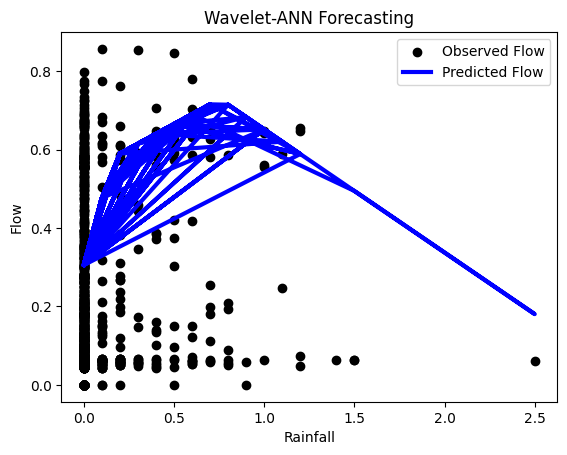

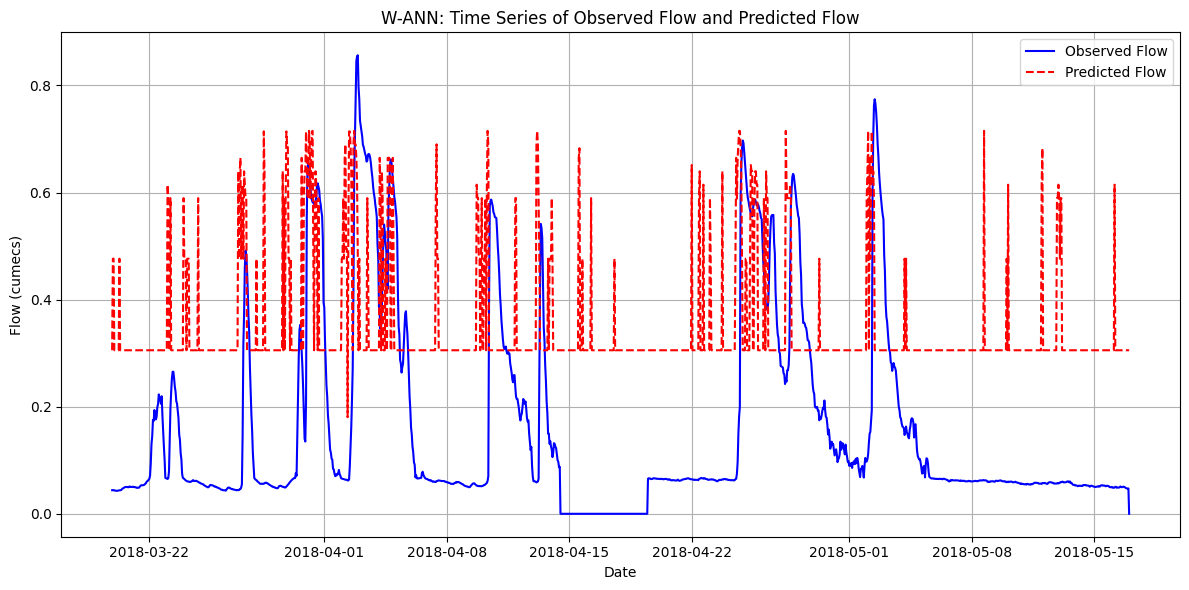

In [18]:
import pandas as pd
import numpy as np
import pywt
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import itertools

# Function to perform wavelet decomposition
def wavelet_transform(data, wavelet='db1', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return np.concatenate(coeffs)

# Load the data
drive.mount('/content/drive/', force_remount=True)
#file_path = '/content/drive/MyDrive/dataset/crowden_river_data.csv'
file_path = '/content/drive/MyDrive/dataset/crowden_river_data_2018_hr.csv'

df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')

# Split the data into training and testing sets
split_index = int(0.3 * len(df))
train_data = df[:split_index]
test_data = df[split_index:]

# Prepare the training and testing data
rain_X_train = train_data[['Rainfall Woodhead']].values
flow_y_train = train_data['Flow'].values
rain_X_test = test_data[['Rainfall Woodhead']].values
flow_y_test = test_data['Flow'].values
date_test = test_data['Date'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
rain_X_train_scaled = scaler.fit_transform(rain_X_train)
rain_X_test_scaled = scaler.transform(rain_X_test)

# Perform wavelet transform and extract features
wavelet_level = 3  # Adjust as needed
rain_X_train_wavelet = np.apply_along_axis(wavelet_transform, 1, rain_X_train_scaled, level=wavelet_level)
rain_X_test_wavelet = np.apply_along_axis(wavelet_transform, 1, rain_X_test_scaled, level=wavelet_level)

# Build the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(rain_X_train_wavelet.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
#model.fit(rain_X_train_wavelet, flow_y_train, epochs=100, batch_size=64)
model.fit(rain_X_train_wavelet, flow_y_train, epochs=100, batch_size=32)

# Make predictions
flow_y_pred = model.predict(rain_X_test_wavelet)
flow_y_pred = scaler.inverse_transform(flow_y_pred)

# Evaluate the model
score = r2_score(flow_y_test, flow_y_pred)
mse = mean_squared_error(flow_y_test, flow_y_pred)
print('R-squared score:', score)
print('Mean Squared Error:', mse)

# Prepare to calculate Nash-Sutcliffe Efficiency (NSE)and PBIAS

# Observed and predicted values
observed_values = flow_y_test
predicted_values = flow_y_pred

# Calculate mean of observed values
observed_mean = np.mean(observed_values)

# Calculate Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observed_values - predicted_values) ** 2) / np.sum((observed_values - observed_mean) ** 2))

# Calculate Percent Bias (PBIAS)
pbias = (np.sum(observed_values - predicted_values) / np.sum(observed_values)) * 100

print("Nash-Sutcliffe Efficiency (NSE):", nse)
print("Percent Bias (PBIAS):", pbias)

# Plot outputs
plt.scatter(rain_X_test, flow_y_test, color='black', label='Observed Flow')
plt.plot(rain_X_test, flow_y_pred, color='blue', linewidth=3, label='Predicted Flow')
plt.xlabel('Rainfall')
plt.ylabel('Flow')
plt.title('Wavelet-ANN Forecasting')
plt.legend()
plt.show()

# Plot time series of observed flow and predicted flow
plt.figure(figsize=(12, 6))
plt.plot(date_test, flow_y_test, label='Observed Flow', color='blue')
plt.plot(date_test, flow_y_pred, label='Predicted Flow', linestyle='--', color='red')
#plt.plot(flow_y_test, label='Observed Flow', color='blue')
#plt.plot(flow_y_pred, label='Predicted Flow', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Flow (cumecs)')
plt.title('W-ANN: Time Series of Observed Flow and Predicted Flow')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Write model results to CSV file
#results_df = pd.DataFrame({'Date': test_data['Date'], 'Temperature': temp_X_test.ravel(),
#                           'Observed Flow': flow_y_test, 'Predicted Flow': flow_y_pred.ravel()})
#results_df.to_csv('/content/drive/MyDrive/dataset/output/crowden_pred_wavelet_ANN_flow.csv', index=False)
#print("File saved successfully!")


**SARIMA**

In [ ]:
#SARIMA model to fit a timeseries of temperature to flow
#Change % split of training, and p.d.q values
#IMPORT LIBARIES
import pandas as pd # pandas for data manipulation
import numpy as np # numpy for numerical operations
from google.colab import drive # used in Google Colab notebooks to mount Google Drive
import matplotlib.pyplot as plt # for plotting a graph.
import matplotlib.dates as mdates # for plotting dates on graphs
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error

import itertools
import warnings
warnings.filterwarnings("ignore")

# NAME AND STUDENT ID
print('Andrew Lowe')
print ('ID 1223456')

# LOAD DATA CSV FILES

# Mount Google Drive
drive.mount('/content/drive/', force_remount=True)

# Load the temperature and observed flow data in CSV file from Google Drive
#file_path = '/content/drive/MyDrive/dataset/crowden_river_data.csv'
file_path = '/content/drive/MyDrive/dataset/crowden_river_data_2018_hr.csv'

# Read climate data from CSV file and create a DataFrame
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')


# SPLIT DATA INTO TRAINING AND TEST SETS AND PREPARE DATA SETS

# Split the data into training and testing sets (30% training, 70% testing then 50%).
#split_index = int(0.3 * len(df)) # % of the data for training
split_index = int(0.6 * len(df)) # % of the data for training

# The df[:split_index] is called DataFrame slicing, where the train_data = df[:split_index] creates a new DataFrame called train_data containing the first split_index rows of the original DataFrame df
train_data = df[:split_index] # Training data contains the first % of the data
test_data = df[split_index:] # Testing data contains the remaining % of the data

#print(train_data.columns)

# Prepare the training and testing data. This reads columns 2 (Temp) and 3 (Observed Flow) from CSV file
rain_X_train = train_data[['Rainfall']].values
flow_y_train = train_data['Flow'].values
rain_X_test = test_data[['Rainfall']].values
flow_y_test = test_data['Flow'].values
date_test = test_data ['Date']

# DEFINE p, d, q, P, D, Q, and m PARAMETER VALUES AND MAKE PREDICTION OF FLOW USING SARIMA ON TESTING DATA

# Define range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregression order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregression order
D_values = range(0, 2)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order

m = 96  # Seasonal period (assuming 24 hours per day with 15 min timestep)

best_aic = float("inf")  # Initialize best AIC
best_order = None
best_seasonal_order = None

# Iterate over all combinations of p, d, q, P, D, Q values
for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, m)
    try:
        # Fit SARIMA model
        model = SARIMAX(flow_y_train, exog=rain_X_train, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        sarima_results = model.fit()

        # Calculate AIC
        aic = sarima_results.aic

        # Update best AIC, order, and seasonal_order if current model has lower AIC
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_seasonal_order = seasonal_order
    except:
        continue

print("Best AIC:", best_aic)
print("Best Order (p, d, q):", best_order)
print("Best Seasonal Order (P, D, Q, m):", best_seasonal_order)

# Fit SARIMA model with best order and seasonal order
best_model = SARIMAX(flow_y_train, exog=rain_X_train, order=best_order, seasonal_order=best_seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False)
best_sarima_results = best_model.fit()

# Make predictions using SARIMA on testing data
flow_y_pred = best_sarima_results.forecast(steps=len(rain_X_test), exog=rain_X_test)
#flow_y_pred = best_sarima_results.forecast(steps=len(rain_X_test))

# EVALUATE MODEL PERFORMACE

# EVALUATE THE ARIMA MODEL PERFORMANCE

# Calculate the R-squared score
score = r2_score(flow_y_test, flow_y_pred)
print('R-squared score:', score)

# EVALUATE THE PERFORMANCE OF THE GLACIER RUNOFF MODEL

# Evaluate runoff model results (1) with simple r2 and mean standard error (mse)

# Calculate evaluation metrics for total predicted flow
r2 = r2_score(flow_y_test, flow_y_pred)
mse = mean_squared_error(flow_y_test, flow_y_pred)

# Print evaluation metrics for total predicted flow
print("Evaluation Metrics for Total Predicted Flow:")
print(f"R2: {r2:.2f}")
print(f"MSE: {mse:.2f}")

# Evaluate runof model results (2) using Nash-Sutcliffe Efficiency (NSE)and PBIAS

# Prepare to calculate Nash-Sutcliffe Efficiency (NSE)and PBIAS

# Observed and predicted values
observed_values = flow_y_test
predicted_values = flow_y_pred

# Calculate mean of observed values
observed_mean = np.mean(observed_values)

# Calculate Nash-Sutcliffe Efficiency (NSE)
nse = 1 - (np.sum((observed_values - predicted_values) ** 2) / np.sum((observed_values - observed_mean) ** 2))

# Calculate Percent Bias (PBIAS)
pbias = (np.sum(observed_values - predicted_values) / np.sum(observed_values)) * 100

print("Nash-Sutcliffe Efficiency (NSE):", nse)
print("Percent Bias (PBIAS):", pbias)


# CREATE SCATTER PLOT OF TEMPERATURE AND PREDICTED FLOW FOR TEST DATA

# Plot outputs
plt.scatter(rain_X_test, flow_y_test, color="black")
plt.plot(rain_X_test, flow_y_pred, color="blue", linewidth=3)

plt.xlabel('Rainfall')
plt.ylabel('Predicted Flow')
plt.title('SARIMA: Rainfall vs Flow')

plt.show()


# CREATE TIME SERIES PLOT OF OBSERVED FLOW and PREDICTED FLOW FOR TEST PERIOD

# Plot time series of observed flow and predicted flow
plt.figure(figsize=(12, 6))
plt.plot(date_test, flow_y_test, label='Observed Flow', color='blue')
plt.plot(date_test, flow_y_pred, label='Predicted Flow', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Flow (cumecs)')
plt.title('SARIMA: Time Series of Observed Flow and Predicted Runoff')
plt.legend()

#Set range for y-axis
plt.ylim(0, 1)

# Set x-axis major and minor intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Major interval: 1 day
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(interval=12))  # Minor interval: 6 hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format the major ticks as 'DD-MM-YYYY'

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Plot GRID
plt.grid(True)
plt.tight_layout()

plt.show()


# WRITE MODEL RESULTS TO CSV FILE

# Write the predictions to a file on Google Drive and confirm file is saved

# Convert multi-dimensional arrays to one-dimensional arrays if necessary
rain_X_test = rain_X_test.ravel()  # Ensure temp_X_test is one-dimensional
flow_y_pred = flow_y_pred.ravel()  # Ensure flow_y_pred is one-dimensional

# Create DataFrame with one-dimensional arrays
#results_df = pd.DataFrame({'Date': date_test,'Rainfall': rain_X_test, 'Observed Flow': flow_y_test, 'Predicted Flow': flow_y_pred})

# Write the DataFrame to a CSV file
#results_df.to_csv('/content/drive/MyDrive/dataset/output/crowden_pred_SARIMA_ML_flow.csv', index=False)

#print("File saved successfully!")

Andrew Lowe
ID 1223456
Mounted at /content/drive/
